In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.metrics import mape
from darts.models import TFTModel
from darts.utils.likelihood_models.torch import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_values(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [3]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [4]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Epoch 5:  40%|████      | 2/5 [00:10<00:16,  5.44s/it, train_loss=0.735]

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:44<00:00, 44.01s/it]


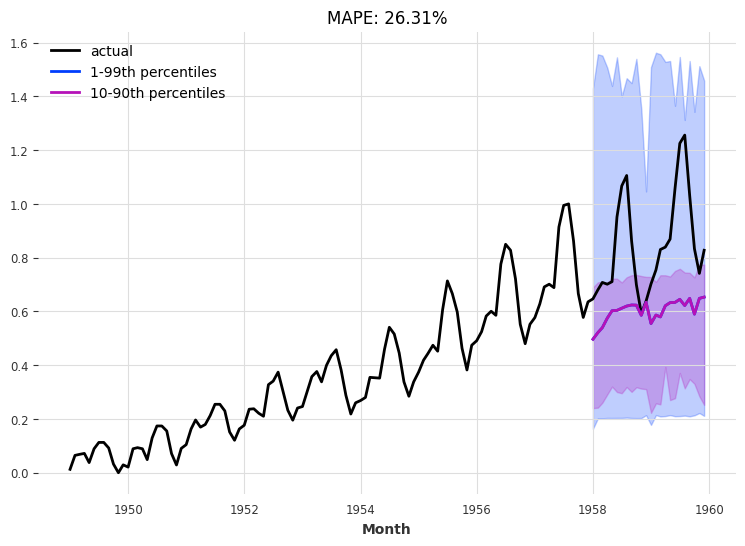

In [6]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"


def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title(f"MAPE: {mape(val_series, pred_series):.2f}%")
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s]


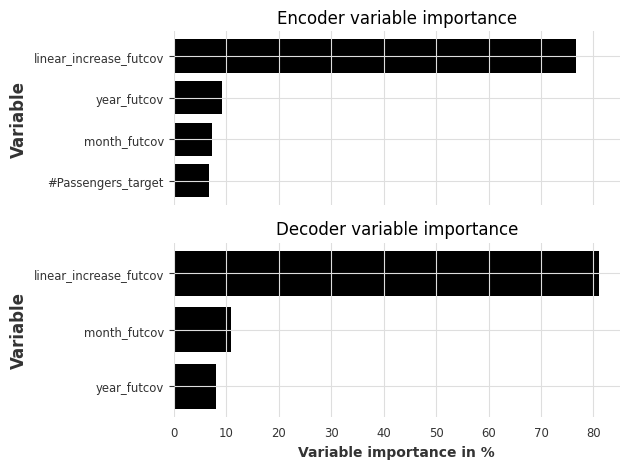

In [7]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(my_model)
explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result)

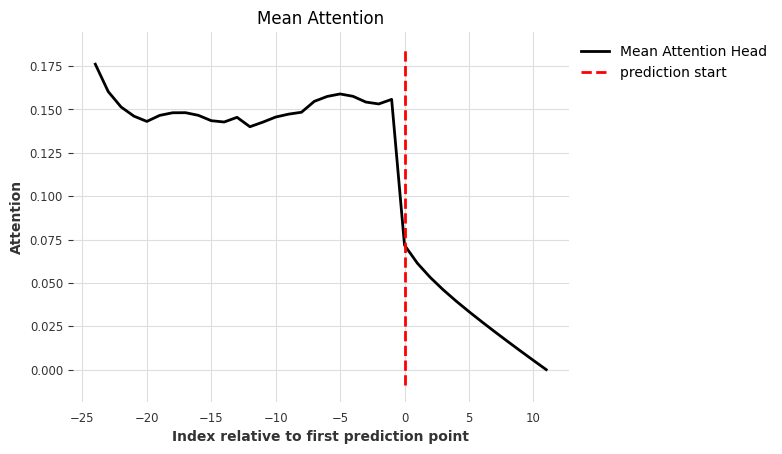

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [8]:
explainer.plot_attention(explainability_result, plot_type="time")

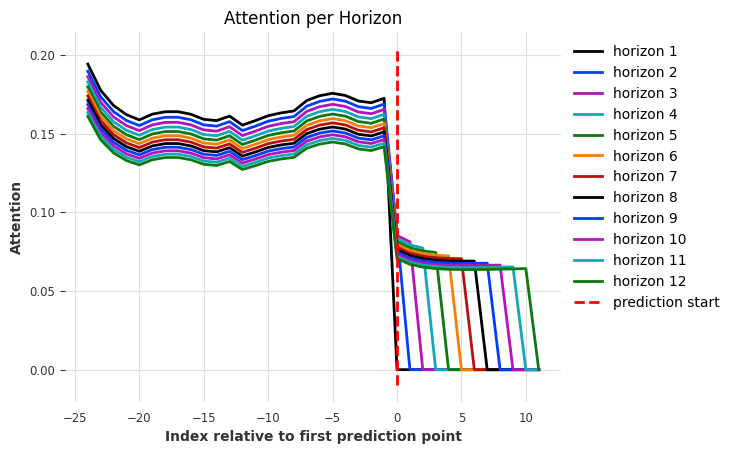

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [9]:
explainer.plot_attention(explainability_result, plot_type="all")

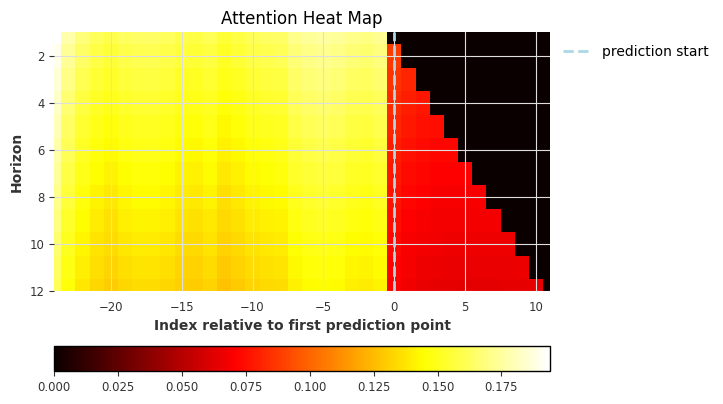

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [10]:
explainer.plot_attention(explainability_result, plot_type="heatmap")

In [11]:
explainability_result.get_encoder_importance()

,#Passengers_target,month_futcov,year_futcov,linear_increase_futcov
0,6.7,7.4,9.3,76.599998


In [12]:
explainability_result.get_decoder_importance()

,year_futcov,month_futcov,linear_increase_futcov
0,8.1,10.9,81.0


In [13]:
explainability_result.get_static_covariates_importance()

""


<Axes: xlabel='Month'>

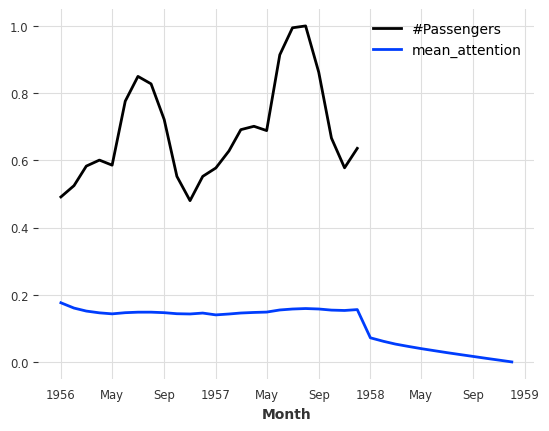

In [14]:
attention = explainability_result.get_attention().mean(axis=1)

time_intersection = train_transformed.time_index.intersection(attention.time_index)

train_transformed[time_intersection].plot()
attention.plot(label="mean_attention", max_nr_components=12)